<center><img src='https://netacad.centralesupelec.fr/img/cs.jpg' width=200></center>

<h6><center>Predicting TGV Retards</center></h6>



### Importing libraries

In [1]:
1 # Utilitaries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sn
from sklearn.preprocessing import StandardScaler

# Deep learning libraries
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, f1_score,r2_score


2023-10-22 16:38:36.786451: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-22 16:38:36.786495: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-22 16:38:36.786514: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-22 16:38:36.791013: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2023-10-22 16:38:38.038245: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-22 16:38:38.041363: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-22 16:38:38.041614: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

### Hyperparameters

In [3]:
SEED = 42
Batch_size = 32

In [4]:
# Set the seed for NumPy
np.random.seed(42)

# Set the seed for TensorFlow
tf.random.set_seed(42)

### Getting the data

In [5]:
retards_df = pd.read_csv("data/regularite-mensuelle-tgv-aqst.csv", sep=';')
retards_df.head()


,date,service,gare_depart,gare_arrivee,duree_moyenne,nb_train_prevu,nb_annulation,commentaire_annulation,nb_train_depart_retard,retard_moyen_depart,...,nb_train_retard_sup_15,retard_moyen_trains_retard_sup15,nb_train_retard_sup_30,nb_train_retard_sup_60,prct_cause_externe,prct_cause_infra,prct_cause_gestion_trafic,prct_cause_materiel_roulant,prct_cause_gestion_gare,prct_cause_prise_en_charge_voyageurs
0,2018-01,National,BORDEAUX ST JEAN,PARIS MONTPARNASSE,141,870,5,NaN,289,11.247809,...,110,6.511118,44,8,36.134454,31.092437,10.924370,15.966387,5.042017,0.840336
1,2018-01,National,LA ROCHELLE VILLE,PARIS MONTPARNASSE,165,222,0,NaN,8,2.875000,...,22,5.696096,5,0,15.384615,30.769231,38.461538,11.538462,3.846154,0.000000
2,2018-01,National,PARIS MONTPARNASSE,QUIMPER,220,248,1,NaN,37,9.501351,...,26,7.548387,17,7,26.923077,38.461538,15.384615,19.230769,0.000000,0.000000
3,2018-01,National,PARIS MONTPARNASSE,ST MALO,156,102,0,NaN,12,19.912500,...,8,6.724757,6,4,23.076923,46.153846,7.692308,15.384615,7.692308,0.000000
4,2018-01,National,PARIS MONTPARNASSE,ST PIERRE DES CORPS,61,391,2,NaN,61,7.796995,...,17,3.346487,6,0,21.212121,42.424242,9.090909,21.212121,6.060606,0.000000


In [6]:
test = retards_df.head()
test.to_latex(index=False)

/tmp/ipykernel_66949/3904325971.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  test.to_latex(index=False)


"\\begin{tabular}{llllrrrrrrrrrrrlrrrrrrrrrr}\n\\toprule\n   date &  service &        gare\\_depart &        gare\\_arrivee &  duree\\_moyenne &  nb\\_train\\_prevu &  nb\\_annulation &  commentaire\\_annulation &  nb\\_train\\_depart\\_retard &  retard\\_moyen\\_depart &  retard\\_moyen\\_tous\\_trains\\_depart &  commentaire\\_retards\\_depart &  nb\\_train\\_retard\\_arrivee &  retard\\_moyen\\_arrivee &  retard\\_moyen\\_tous\\_trains\\_arrivee &                        commentaires\\_retard\\_arrivee &  nb\\_train\\_retard\\_sup\\_15 &  retard\\_moyen\\_trains\\_retard\\_sup15 &  nb\\_train\\_retard\\_sup\\_30 &  nb\\_train\\_retard\\_sup\\_60 &  prct\\_cause\\_externe &  prct\\_cause\\_infra &  prct\\_cause\\_gestion\\_trafic &  prct\\_cause\\_materiel\\_roulant &  prct\\_cause\\_gestion\\_gare &  prct\\_cause\\_prise\\_en\\_charge\\_voyageurs \\\\\n\\midrule\n2018-01 & National &   BORDEAUX ST JEAN &  PARIS MONTPARNASSE &            141 &             870 &              5 &       

### Data analysis

In [7]:
retards_df.describe()

,duree_moyenne,nb_train_prevu,nb_annulation,commentaire_annulation,nb_train_depart_retard,retard_moyen_depart,retard_moyen_tous_trains_depart,commentaire_retards_depart,nb_train_retard_arrivee,retard_moyen_arrivee,...,nb_train_retard_sup_15,retard_moyen_trains_retard_sup15,nb_train_retard_sup_30,nb_train_retard_sup_60,prct_cause_externe,prct_cause_infra,prct_cause_gestion_trafic,prct_cause_materiel_roulant,prct_cause_gestion_gare,prct_cause_prise_en_charge_voyageurs
count,8154.000000,8154.000000,8154.000000,0.0,8154.000000,8154.000000,8154.000000,0.0,8154.000000,8154.000000,...,8154.000000,8154.000000,8154.000000,8154.000000,8154.000000,8154.000000,8154.000000,8154.000000,8154.000000,8154.000000
mean,169.860314,257.198308,11.349644,NaN,88.434265,11.205745,3.076737,NaN,34.516066,33.950971,...,24.434511,32.193823,11.642016,4.245892,23.266846,21.888418,19.052124,18.995179,6.714513,7.127315
std,87.390774,173.815703,26.544553,NaN,90.384803,12.476780,5.432676,NaN,29.729349,15.702663,...,21.400761,20.195926,11.225104,4.901032,16.805192,15.692521,14.947548,14.256533,8.080759,10.249453
min,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,-229.269444,NaN,0.000000,-40.109259,...,0.000000,-4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,100.000000,142.000000,0.000000,NaN,22.000000,5.128410,1.140258,NaN,13.000000,24.636941,...,9.000000,12.140350,4.000000,1.000000,11.764706,11.538462,8.695652,9.523810,0.000000,0.000000
50%,164.000000,221.000000,3.000000,NaN,55.000000,9.036447,2.248271,NaN,27.000000,32.441236,...,19.000000,34.932765,9.000000,3.000000,20.967742,20.000000,16.949153,17.165179,5.000000,3.703704
75%,221.000000,333.000000,10.000000,NaN,129.000000,14.219375,3.903651,NaN,47.000000,41.346717,...,33.000000,44.268749,16.000000,6.000000,32.307692,30.000000,26.923077,26.086957,10.000000,10.000000
max,786.000000,1075.000000,297.000000,NaN,596.000000,316.188095,84.516667,NaN,376.000000,299.600000,...,312.000000,299.600000,202.000000,71.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000


In [8]:
retards_df.info()   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8154 entries, 0 to 8153
Data columns (total 26 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   date                                  8154 non-null   object 
 1   service                               8154 non-null   object 
 2   gare_depart                           8154 non-null   object 
 3   gare_arrivee                          8154 non-null   object 
 4   duree_moyenne                         8154 non-null   int64  
 5   nb_train_prevu                        8154 non-null   int64  
 6   nb_annulation                         8154 non-null   int64  
 7   commentaire_annulation                0 non-null      float64
 8   nb_train_depart_retard                8154 non-null   int64  
 9   retard_moyen_depart                   8154 non-null   float64
 10  retard_moyen_tous_trains_depart       8154 non-null   float64
 11  commentaire_retar

data_to_delete = ["commentaire_annulation", "commentaires_retard_arrivee", "nb_annulation", "commentaire_retards_depart", "nb_train_retard_sup_15","retard_moyen_trains_retard_sup15","nb_train_retard_sup_30", "nb_train_retard_sup_60"]

In [9]:
data_to_delete = ["commentaire_annulation", "commentaires_retard_arrivee", "commentaire_retards_depart"]

In [10]:
# Drop the specified columns from the DataFrame
retards_df = retards_df.drop(columns=data_to_delete)
retards_df.head()

,date,service,gare_depart,gare_arrivee,duree_moyenne,nb_train_prevu,nb_annulation,nb_train_depart_retard,retard_moyen_depart,retard_moyen_tous_trains_depart,...,nb_train_retard_sup_15,retard_moyen_trains_retard_sup15,nb_train_retard_sup_30,nb_train_retard_sup_60,prct_cause_externe,prct_cause_infra,prct_cause_gestion_trafic,prct_cause_materiel_roulant,prct_cause_gestion_gare,prct_cause_prise_en_charge_voyageurs
0,2018-01,National,BORDEAUX ST JEAN,PARIS MONTPARNASSE,141,870,5,289,11.247809,3.693179,...,110,6.511118,44,8,36.134454,31.092437,10.924370,15.966387,5.042017,0.840336
1,2018-01,National,LA ROCHELLE VILLE,PARIS MONTPARNASSE,165,222,0,8,2.875000,0.095796,...,22,5.696096,5,0,15.384615,30.769231,38.461538,11.538462,3.846154,0.000000
2,2018-01,National,PARIS MONTPARNASSE,QUIMPER,220,248,1,37,9.501351,1.003981,...,26,7.548387,17,7,26.923077,38.461538,15.384615,19.230769,0.000000,0.000000
3,2018-01,National,PARIS MONTPARNASSE,ST MALO,156,102,0,12,19.912500,1.966667,...,8,6.724757,6,4,23.076923,46.153846,7.692308,15.384615,7.692308,0.000000
4,2018-01,National,PARIS MONTPARNASSE,ST PIERRE DES CORPS,61,391,2,61,7.796995,0.886889,...,17,3.346487,6,0,21.212121,42.424242,9.090909,21.212121,6.060606,0.000000


In [11]:
def get_month(row):
    date = int(row["date"][-2:])
    return date
retards_df.insert(1,"mois",retards_df.apply(get_month, axis=1))

#df = pd.to_datetime(retards_df['date']).dt.strftime('%Y-%m')
retards_df

,date,mois,service,gare_depart,gare_arrivee,duree_moyenne,nb_train_prevu,nb_annulation,nb_train_depart_retard,retard_moyen_depart,...,nb_train_retard_sup_15,retard_moyen_trains_retard_sup15,nb_train_retard_sup_30,nb_train_retard_sup_60,prct_cause_externe,prct_cause_infra,prct_cause_gestion_trafic,prct_cause_materiel_roulant,prct_cause_gestion_gare,prct_cause_prise_en_charge_voyageurs
0,2018-01,1,National,BORDEAUX ST JEAN,PARIS MONTPARNASSE,141,870,5,289,11.247809,...,110,6.511118,44,8,36.134454,31.092437,10.924370,15.966387,5.042017,0.840336
1,2018-01,1,National,LA ROCHELLE VILLE,PARIS MONTPARNASSE,165,222,0,8,2.875000,...,22,5.696096,5,0,15.384615,30.769231,38.461538,11.538462,3.846154,0.000000
2,2018-01,1,National,PARIS MONTPARNASSE,QUIMPER,220,248,1,37,9.501351,...,26,7.548387,17,7,26.923077,38.461538,15.384615,19.230769,0.000000,0.000000
3,2018-01,1,National,PARIS MONTPARNASSE,ST MALO,156,102,0,12,19.912500,...,8,6.724757,6,4,23.076923,46.153846,7.692308,15.384615,7.692308,0.000000
4,2018-01,1,National,PARIS MONTPARNASSE,ST PIERRE DES CORPS,61,391,2,61,7.796995,...,17,3.346487,6,0,21.212121,42.424242,9.090909,21.212121,6.060606,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8149,2023-06,6,National,STRASBOURG,PARIS EST,114,492,2,273,11.989927,...,80,35.446667,31,10,7.619048,5.714286,55.238095,18.095238,7.619048,5.714286
8150,2023-06,6,National,TOULOUSE MATABIAU,PARIS MONTPARNASSE,273,215,0,24,28.730556,...,36,76.688889,24,10,13.888889,33.333333,8.333333,19.444444,8.333333,16.666667
8151,2023-06,6,National,TOURS,PARIS MONTPARNASSE,78,192,1,20,31.281667,...,13,97.394872,7,5,14.285714,21.428571,28.571429,21.428571,3.571429,10.714286
8152,2023-06,6,National,VALENCE ALIXAN TGV,PARIS LYON,133,440,2,347,13.517051,...,96,47.424479,62,22,26.724138,19.827586,27.586207,7.758621,7.758621,10.344828


In [12]:
retards_df['total_retard_mean'] = retards_df['retard_moyen_depart'] + retards_df['retard_moyen_arrivee']

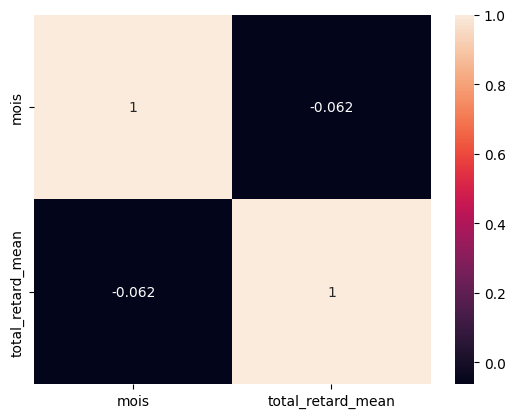

In [13]:
df_corr = retards_df[["mois","total_retard_mean"]]
corr_matrix = df_corr.corr()
sn.heatmap(corr_matrix, annot= True)
plt.show()

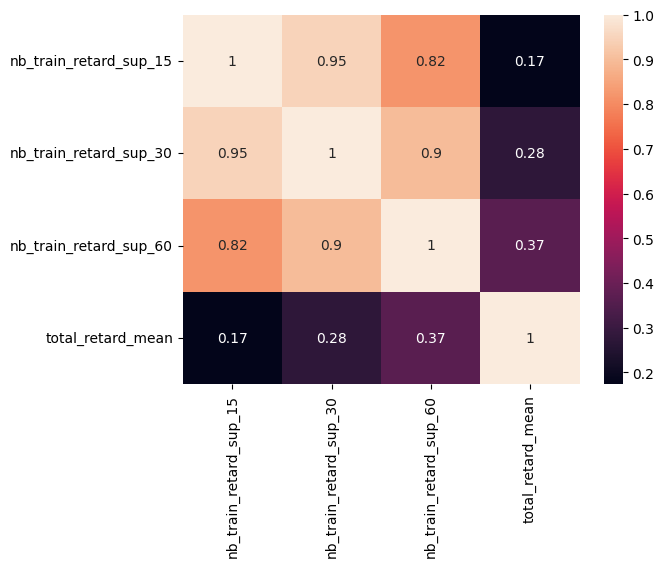

In [14]:
df_corr = retards_df[["nb_train_retard_sup_15","nb_train_retard_sup_30","nb_train_retard_sup_60","total_retard_mean"]]
corr_matrix = df_corr.corr()
sn.heatmap(corr_matrix, annot= True)
plt.show()

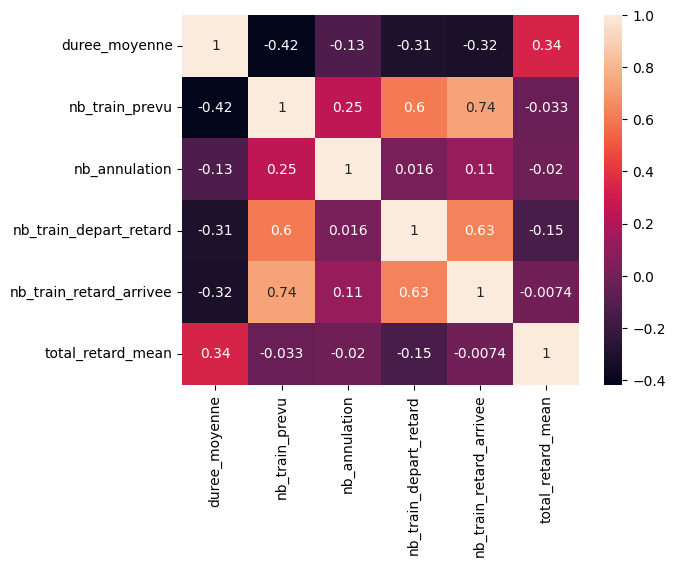

In [15]:
df_corr = retards_df[["duree_moyenne","nb_train_prevu","nb_annulation","nb_train_depart_retard","nb_train_retard_arrivee","total_retard_mean"]]
corr_matrix = df_corr.corr()
sn.heatmap(corr_matrix, annot= True)
plt.show()

In [16]:
retard_columns_to_delete = ["nb_train_retard_sup_15","nb_train_retard_sup_30","nb_train_retard_sup_60","retard_moyen_depart","retard_moyen_tous_trains_depart", "retard_moyen_arrivee", "retard_moyen_tous_trains_arrivee"]
retards_df = retards_df.drop(columns=retard_columns_to_delete)
retards_df.head()

,date,mois,service,gare_depart,gare_arrivee,duree_moyenne,nb_train_prevu,nb_annulation,nb_train_depart_retard,nb_train_retard_arrivee,retard_moyen_trains_retard_sup15,prct_cause_externe,prct_cause_infra,prct_cause_gestion_trafic,prct_cause_materiel_roulant,prct_cause_gestion_gare,prct_cause_prise_en_charge_voyageurs,total_retard_mean
0,2018-01,1,National,BORDEAUX ST JEAN,PARIS MONTPARNASSE,141,870,5,289,147,6.511118,36.134454,31.092437,10.924370,15.966387,5.042017,0.840336,39.684543
1,2018-01,1,National,LA ROCHELLE VILLE,PARIS MONTPARNASSE,165,222,0,8,34,5.696096,15.384615,30.769231,38.461538,11.538462,3.846154,0.000000,24.399020
2,2018-01,1,National,PARIS MONTPARNASSE,QUIMPER,220,248,1,37,26,7.548387,26.923077,38.461538,15.384615,19.230769,0.000000,0.000000,65.193659
3,2018-01,1,National,PARIS MONTPARNASSE,ST MALO,156,102,0,12,13,6.724757,23.076923,46.153846,7.692308,15.384615,7.692308,0.000000,68.535577
4,2018-01,1,National,PARIS MONTPARNASSE,ST PIERRE DES CORPS,61,391,2,61,71,3.346487,21.212121,42.424242,9.090909,21.212121,6.060606,0.000000,20.202159


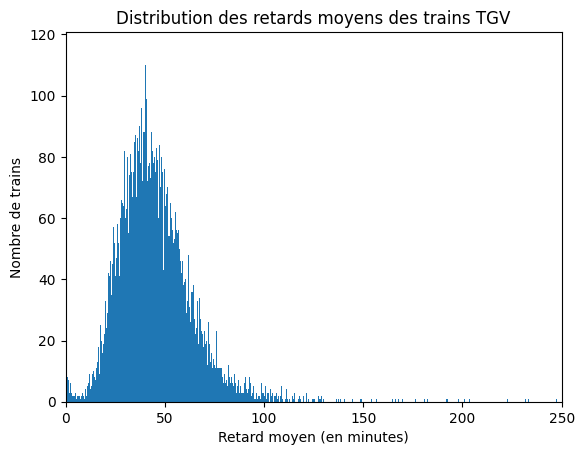

In [17]:
plt.hist(retards_df['total_retard_mean'],bins=1000)

# Add labels and title
plt.xlabel('Retard moyen (en minutes)')
plt.xlim([0, 250])
plt.ylabel('Nombre de trains')
plt.title('Distribution des retards moyens des trains TGV')
plt.show()

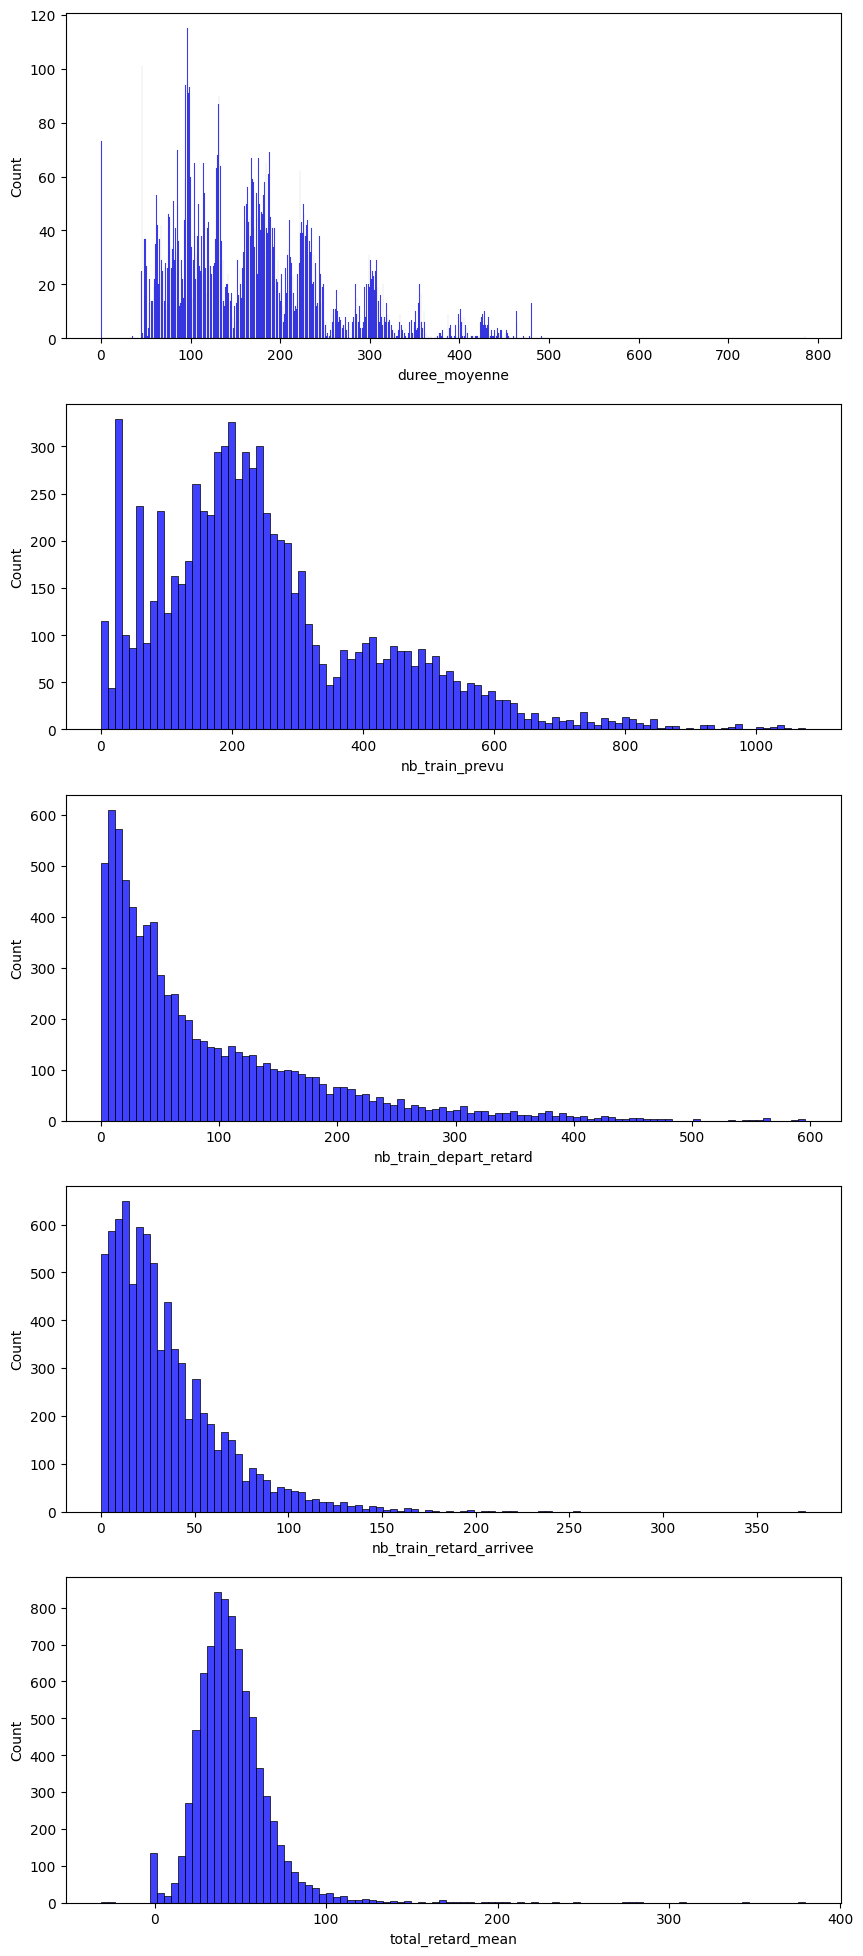

In [18]:
fig, ax = plt.subplots(5,1,  figsize=(10, 10))
plt.subplots_adjust(top = 2)

sn.histplot(retards_df['duree_moyenne'], color='b', bins=1000, ax=ax[0]);
sn.histplot(retards_df['nb_train_prevu'], color='b', bins=100, ax=ax[1]);
sn.histplot(retards_df['nb_train_depart_retard'], color='b', bins=100, ax=ax[2]);
sn.histplot(retards_df['nb_train_retard_arrivee'], color='b', bins=100, ax=ax[3]);
sn.histplot(retards_df['total_retard_mean'], color='b', bins=100, ax=ax[4]);


In [19]:
scaler = StandardScaler()
columns_to_divide = ["prct_cause_externe", "prct_cause_infra", "prct_cause_gestion_trafic", "prct_cause_materiel_roulant", "prct_cause_gestion_gare", "prct_cause_prise_en_charge_voyageurs"]
columns_to_standardize = retards_df.columns.drop(["date","service", "gare_depart","gare_arrivee"] + columns_to_divide)

retards_df[columns_to_divide] /= 100
retards_df[columns_to_standardize] = scaler.fit_transform(retards_df[columns_to_standardize])

In [20]:
retards_df.head()

,date,mois,service,gare_depart,gare_arrivee,duree_moyenne,nb_train_prevu,nb_annulation,nb_train_depart_retard,nb_train_retard_arrivee,retard_moyen_trains_retard_sup15,prct_cause_externe,prct_cause_infra,prct_cause_gestion_trafic,prct_cause_materiel_roulant,prct_cause_gestion_gare,prct_cause_prise_en_charge_voyageurs,total_retard_mean
0,2018-01,-1.521633,National,BORDEAUX ST JEAN,PARIS MONTPARNASSE,-0.330265,3.525799,-0.239222,2.219157,3.783831,-1.271756,0.361345,0.310924,0.109244,0.159664,0.050420,0.008403,-0.248774
1,2018-01,-1.521633,National,LA ROCHELLE VILLE,PARIS MONTPARNASSE,-0.055619,-0.202516,-0.427596,-0.889964,-0.017360,-1.312114,0.153846,0.307692,0.384615,0.115385,0.038462,0.000000,-0.943681
2,2018-01,-1.521633,National,PARIS MONTPARNASSE,QUIMPER,0.573776,-0.052923,-0.389921,-0.569094,-0.286471,-1.220392,0.269231,0.384615,0.153846,0.192308,0.000000,0.000000,0.910914
3,2018-01,-1.521633,National,PARIS MONTPARNASSE,ST MALO,-0.158611,-0.892945,-0.427596,-0.845706,-0.723776,-1.261177,0.230769,0.461538,0.076923,0.153846,0.076923,0.000000,1.062843
4,2018-01,-1.521633,National,PARIS MONTPARNASSE,ST PIERRE DES CORPS,-1.245749,0.769838,-0.352246,-0.303546,1.227278,-1.428462,0.212121,0.424242,0.090909,0.212121,0.060606,0.000000,-1.134477


In [21]:
retards_df.describe()

,mois,duree_moyenne,nb_train_prevu,nb_annulation,nb_train_depart_retard,nb_train_retard_arrivee,retard_moyen_trains_retard_sup15,prct_cause_externe,prct_cause_infra,prct_cause_gestion_trafic,prct_cause_materiel_roulant,prct_cause_gestion_gare,prct_cause_prise_en_charge_voyageurs,total_retard_mean
count,8.154000e+03,8.154000e+03,8.154000e+03,8.154000e+03,8.154000e+03,8.154000e+03,8.154000e+03,8154.000000,8154.000000,8154.000000,8154.000000,8154.000000,8154.000000,8.154000e+03
mean,-5.576985e-17,1.463959e-16,3.485616e-17,-6.971231e-18,8.365477e-17,2.091369e-17,-2.230794e-16,0.232668,0.218884,0.190521,0.189952,0.067145,0.071273,2.230794e-16
std,1.000061e+00,1.000061e+00,1.000061e+00,1.000061e+00,1.000061e+00,1.000061e+00,1.000061e+00,0.168052,0.156925,0.149475,0.142565,0.080808,0.102495,1.000061e+00
min,-1.521633e+00,-1.943806e+00,-1.479809e+00,-4.275958e-01,-9.784796e-01,-1.161081e+00,-1.792245e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3.477838e+00
25%,-9.404492e-01,-7.994505e-01,-6.628019e-01,-4.275958e-01,-7.350610e-01,-7.237759e-01,-9.930073e-01,0.117647,0.115385,0.086957,0.095238,0.000000,0.000000,-5.859718e-01
50%,-6.867428e-02,-6.706284e-02,-2.082696e-01,-3.145714e-01,-3.699329e-01,-2.528319e-01,1.356269e-01,0.209677,0.200000,0.169492,0.171652,0.050000,0.037037,-1.156556e-01
75%,8.031007e-01,5.852199e-01,4.361306e-01,-5.084761e-02,4.488390e-01,4.199453e-01,5.979259e-01,0.323077,0.300000,0.269231,0.260870,0.100000,0.100000,4.403838e-01
max,1.674876e+00,7.050830e+00,4.705282e+00,1.076183e+01,5.615954e+00,1.148713e+01,1.324141e+01,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.520437e+01


In [22]:
nan_counts = retards_df.isna().sum()

# Display the resulting Series
print(nan_counts)

date                                    0
mois                                    0
service                                 0
gare_depart                             0
gare_arrivee                            0
duree_moyenne                           0
nb_train_prevu                          0
nb_annulation                           0
nb_train_depart_retard                  0
nb_train_retard_arrivee                 0
retard_moyen_trains_retard_sup15        0
prct_cause_externe                      0
prct_cause_infra                        0
prct_cause_gestion_trafic               0
prct_cause_materiel_roulant             0
prct_cause_gestion_gare                 0
prct_cause_prise_en_charge_voyageurs    0
total_retard_mean                       0
dtype: int64


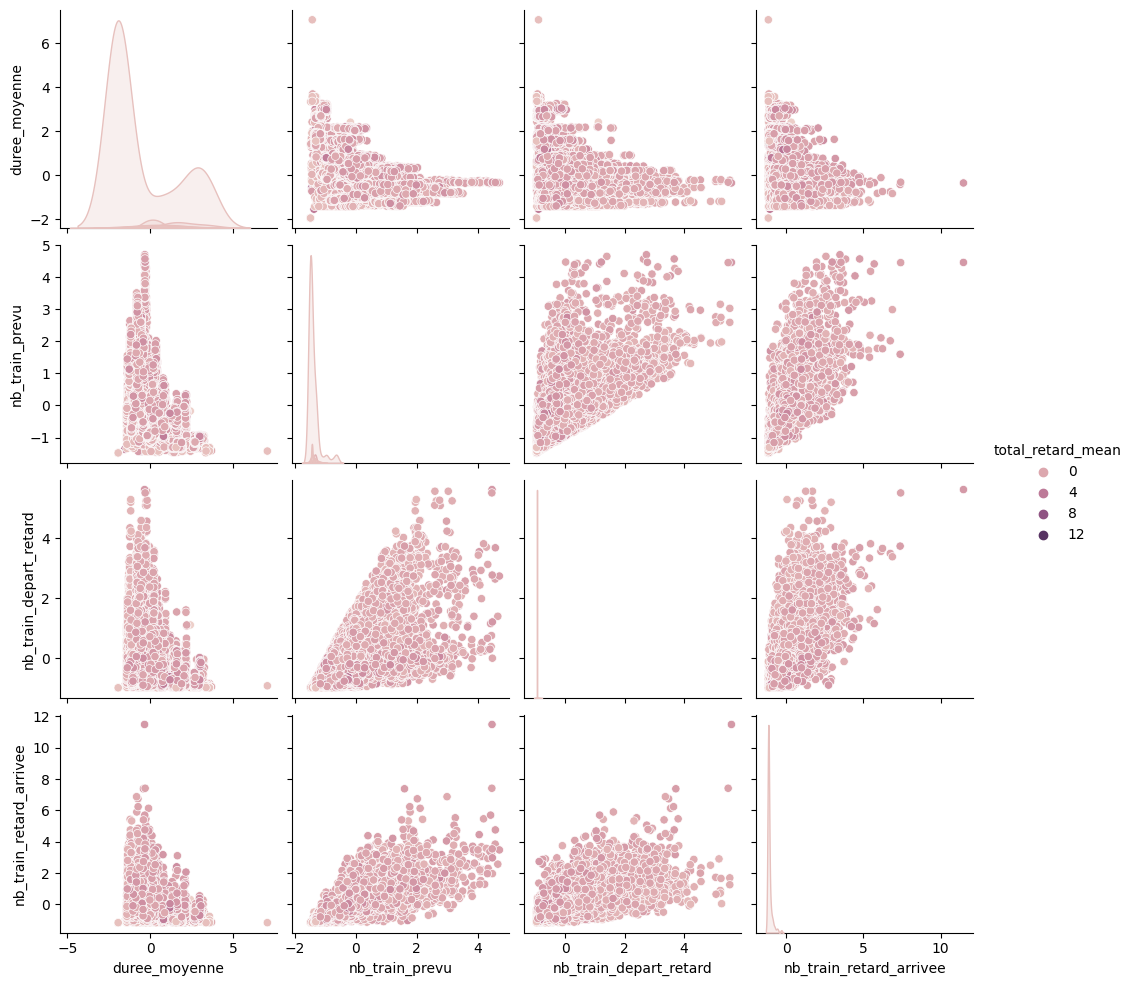

In [23]:
sn.pairplot(retards_df[["duree_moyenne","nb_train_prevu","nb_train_depart_retard","nb_train_retard_arrivee","total_retard_mean"]], hue = 'total_retard_mean', diag_kind='kde');

In [24]:
retards_df.head()

,date,mois,service,gare_depart,gare_arrivee,duree_moyenne,nb_train_prevu,nb_annulation,nb_train_depart_retard,nb_train_retard_arrivee,retard_moyen_trains_retard_sup15,prct_cause_externe,prct_cause_infra,prct_cause_gestion_trafic,prct_cause_materiel_roulant,prct_cause_gestion_gare,prct_cause_prise_en_charge_voyageurs,total_retard_mean
0,2018-01,-1.521633,National,BORDEAUX ST JEAN,PARIS MONTPARNASSE,-0.330265,3.525799,-0.239222,2.219157,3.783831,-1.271756,0.361345,0.310924,0.109244,0.159664,0.050420,0.008403,-0.248774
1,2018-01,-1.521633,National,LA ROCHELLE VILLE,PARIS MONTPARNASSE,-0.055619,-0.202516,-0.427596,-0.889964,-0.017360,-1.312114,0.153846,0.307692,0.384615,0.115385,0.038462,0.000000,-0.943681
2,2018-01,-1.521633,National,PARIS MONTPARNASSE,QUIMPER,0.573776,-0.052923,-0.389921,-0.569094,-0.286471,-1.220392,0.269231,0.384615,0.153846,0.192308,0.000000,0.000000,0.910914
3,2018-01,-1.521633,National,PARIS MONTPARNASSE,ST MALO,-0.158611,-0.892945,-0.427596,-0.845706,-0.723776,-1.261177,0.230769,0.461538,0.076923,0.153846,0.076923,0.000000,1.062843
4,2018-01,-1.521633,National,PARIS MONTPARNASSE,ST PIERRE DES CORPS,-1.245749,0.769838,-0.352246,-0.303546,1.227278,-1.428462,0.212121,0.424242,0.090909,0.212121,0.060606,0.000000,-1.134477


In [25]:
dummies = pd.get_dummies(retards_df[["gare_depart","gare_arrivee","service"]])
dummies

,gare_depart_AIX EN PROVENCE TGV,gare_depart_ANGERS SAINT LAUD,gare_depart_ANGOULEME,gare_depart_ANNECY,gare_depart_ARRAS,gare_depart_AVIGNON TGV,gare_depart_BARCELONA,gare_depart_BELLEGARDE (AIN),gare_depart_BESANCON FRANCHE COMTE TGV,gare_depart_BORDEAUX ST JEAN,...,gare_arrivee_STUTTGART,gare_arrivee_TOULON,gare_arrivee_TOULOUSE MATABIAU,gare_arrivee_TOURCOING,gare_arrivee_TOURS,gare_arrivee_VALENCE ALIXAN TGV,gare_arrivee_VANNES,gare_arrivee_ZURICH,service_International,service_National
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8149,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8150,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8151,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8152,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [26]:
# Concatenate the original DataFrame with the dummy variables
retards_w_dummies_df = pd.concat([retards_df, dummies], axis=1)

In [27]:
retards_w_dummies_df = retards_w_dummies_df.drop(columns=["service","gare_depart","gare_arrivee"])

### Data Class

In [28]:
class DataSets():
    def __init__(self, df, year_to_split = "2023"):
        self.df = df
        self.year_to_split = year_to_split
        self.validate_df_X = pd.DataFrame()
        self.validate_df_Y = pd.DataFrame()
        self.train_df_X = pd.DataFrame()
        self.train_df_Y = pd.DataFrame()
        self.test_df_X = pd.DataFrame()
        self.test_df_Y = pd.DataFrame()
        self.train_dataloader = None
        self.test_dataloader = None
        self.val_dataloader = None

        self.split_data_into_val_test_train()
        self.build_dataloader()

    def get_val_sets(self):
        return self.validate_df_X, self.validate_df_Y

    def get_train_sets(self):
        return self.train_df_X, self.train_df_Y

    def get_test_sets(self):
        return self.test_df_X, self.test_df_Y

    def set_val_sets(self, X, Y):
        self.validate_df_X = X
        self.validate_df_Y = Y

    def set_train_sets(self, X, Y):
        self.train_df_X = X
        self.train_df_Y = Y

    def set_test_sets(self, X, Y):
        self.test_df_X = X
        self.test_df_Y = Y

    def get_train_dataloader(self):
        return self.train_dataloader

    def get_test_dataloader(self):
        return self.test_dataloader

    def get_val_dataloader(self):
        return self.val_dataloader
    
    def split_data_before_after_year(self):
        fitting_df = self.df[self.df['date'] < self.year_to_split]
        validate_df = self.df[self.df['date'] >= self.year_to_split]
        fitting_df = fitting_df.drop("date",axis=1)
        validate_df = validate_df.drop("date",axis=1)
        
        return fitting_df, validate_df
    
    def split_data_into_val_test_train(self):

        fitting_df, validate_df = self.split_data_before_after_year()

        data_to_mantain = ['prct_cause_externe', 'prct_cause_infra', 'prct_cause_gestion_trafic', 'prct_cause_materiel_roulant', 'prct_cause_gestion_gare', 'prct_cause_prise_en_charge_voyageurs', 'total_retard_mean']

        df_Y = fitting_df[data_to_mantain]
        df_X = fitting_df.drop(columns=data_to_mantain)

        validate_df_Y = validate_df[data_to_mantain]
        validate_df_X = validate_df.drop(columns=data_to_mantain)

        train_df_X,test_df_X , train_df_Y,test_df_Y = train_test_split(df_X,df_Y, test_size=0.2, random_state=SEED)
        self.validate_df_X = validate_df_X.reset_index(drop=True)
        self.validate_df_Y = validate_df_Y.reset_index(drop=True)
        self.test_df_X = test_df_X.reset_index(drop=True)
        self.test_df_Y = test_df_Y.reset_index(drop=True)
        self.train_df_X = train_df_X.reset_index(drop=True)
        self.train_df_Y = train_df_Y.reset_index(drop=True)

    def build_dataloader(self, batch_size = 32, model_type= "both"):
        if model_type == 'mean':
            train_Y = self.train_df_Y.iloc[:, -1:].values
            test_Y = self.test_df_Y.iloc[:, -1:].values
            val_Y = self.validate_df_Y.iloc[:, -1:].values
        elif model_type == 'prct':
            train_Y = self.train_df_Y.iloc[:, :-1].values
            test_Y = self.test_df_Y.iloc[:, :-1].values
            val_Y = self.validate_df_Y.iloc[:, :-1].values
        else:
            train_Y = self.train_df_Y.values
            test_Y = self.test_df_Y.values
            val_Y = self.validate_df_Y.values

        self.train_dataloader = tf.data.Dataset.from_tensor_slices((self.train_df_X.values, train_Y)).batch(batch_size=batch_size)
        self.test_dataloader = tf.data.Dataset.from_tensor_slices((self.test_df_X.values, test_Y)).batch(batch_size=batch_size)
        self.val_dataloader = tf.data.Dataset.from_tensor_slices((self.validate_df_X.values, val_Y)).batch(batch_size=batch_size)

###  Models


In [29]:
class MyModel(tf.keras.Model):
  def __init__(self,model_selector = 'both'):
    super().__init__()
    self.flatten = tf.keras.layers.Flatten()
    self.prct_d1 = tf.keras.layers.Dense(128, activation='relu')
    self.prct_d2 = tf.keras.layers.Dense(128, activation='relu')
    self.prct_d3 = tf.keras.layers.Dense(32, activation='relu')
    self.prct_d4 = tf.keras.layers.Dense(16, activation='relu')
    self.prct_out = tf.keras.layers.Dense(6, activation='relu')

    self.mean_d1 = tf.keras.layers.Dense(32, activation='relu')
    self.mean_out = tf.keras.layers.Dense(1, activation='linear')

    self.dropout1 = tf.keras.layers.Dropout(0.5)
    self.dropout2 = tf.keras.layers.Dropout(0.2)
    self.batch_norm1 = tf.keras.layers.BatchNormalization()

    self.model_selector = model_selector

  def prct(self,x):
    x = self.prct_d1(x)
    x = self.batch_norm1(x)
    x = self.dropout1(x)
    x = self.prct_d2(x)
    x = self.dropout1(x)
    x = self.prct_d3(x)
    x = self.dropout2(x)
    x = self.prct_d4(x)
    x = self.dropout2(x)
    x = self.prct_out(x)
    return x 
  
  def mean(self,x):
    x = self.mean_d1(x)
    x = self.dropout1(x)
    x = self.mean_out(x)
    return x
  
  def call(self, x):
    x = self.flatten(x)

    if self.model_selector == 'prct':
      out = self.prct(x)
    elif self.model_selector == 'mean':
      out = self.mean(x)
    else:
      out_mean = self.mean(x)
      out_prct = self.prct(x)
      out = tf.concat([out_prct,out_mean],axis=1)
      
    return out

### Training NN Function   

In [30]:
Datas = DataSets(retards_w_dummies_df)

2023-10-22 16:38:54.881308: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-22 16:38:54.881469: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-22 16:38:54.881573: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [31]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=10, min_lr=0, min_delta = 5e-4, mode='min',verbose=1)

In [32]:
r2_score = tf.keras.metrics.R2Score()
loss_object = tf.keras.losses.MeanSquaredError()
optimizer_mean = tf.keras.optimizers.AdamW(learning_rate = 2e-5,weight_decay=1e-3)
rmse = tf.keras.metrics.RootMeanSquaredError()

Datas.build_dataloader(model_type='mean')
model = MyModel(model_selector='mean')
model.compile(loss=loss_object,optimizer=optimizer_mean,metrics=[r2_score,rmse])
testhistori_mean = model.fit(Datas.get_train_dataloader(),epochs= 400 ,validation_data=Datas.get_test_dataloader(),batch_size=Batch_size)

Epoch 1/400


2023-10-22 16:38:56.278636: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f3078706930 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-22 16:38:56.278665: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2023-10-22 16:38:56.281902: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-22 16:38:56.291290: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-10-22 16:38:56.351598: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


186/186 [==============================] - 2s 3ms/step - loss: 1.3130 - r2_score: -0.3959 - root_mean_squared_error: 1.1459 - val_loss: 1.1978 - val_r2_score: -0.1716 - val_root_mean_squared_error: 1.0945
Epoch 2/400
186/186 [==============================] - 0s 3ms/step - loss: 1.2069 - r2_score: -0.2830 - root_mean_squared_error: 1.0986 - val_loss: 1.1596 - val_r2_score: -0.1343 - val_root_mean_squared_error: 1.0769
Epoch 3/400
186/186 [==============================] - 1s 3ms/step - loss: 1.1775 - r2_score: -0.2518 - root_mean_squared_error: 1.0851 - val_loss: 1.1262 - val_r2_score: -0.1016 - val_root_mean_squared_error: 1.0612
Epoch 4/400
186/186 [==============================] - 0s 2ms/step - loss: 1.1547 - r2_score: -0.2276 - root_mean_squared_error: 1.0746 - val_loss: 1.0965 - val_r2_score: -0.0725 - val_root_mean_squared_error: 1.0471
Epoch 5/400
186/186 [==============================] - 0s 2ms/step - loss: 1.1197 - r2_score: -0.1904 - root_mean_squared_error: 1.0582 - val_lo

In [33]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  0 (unused)
                                                                 
 dense_1 (Dense)             multiple                  0 (unused)
                                                                 
 dense_2 (Dense)             multiple                  0 (unused)
                                                                 
 dense_3 (Dense)             multiple                  0 (unused)
                                                                 
 dense_4 (Dense)             multiple                  0 (unused)
                                                                 
 dense_5 (Dense)             multiple                  409

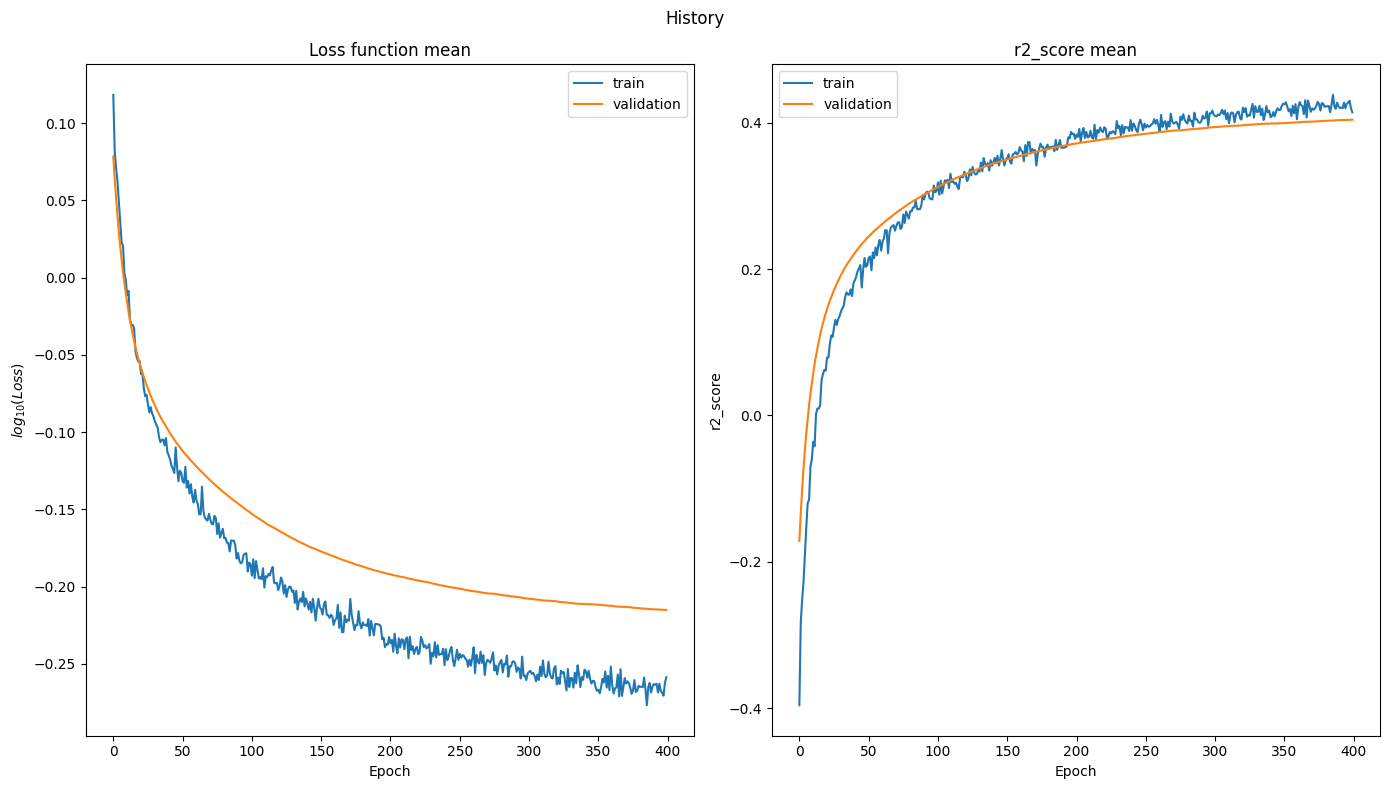

In [34]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 8))
fig.suptitle('History')
axs[0].plot(np.log10(testhistori_mean.history['loss']))
axs[0].plot(np.log10(testhistori_mean.history['val_loss']))
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('$log_{10}(Loss)$')
axs[0].legend(['train', 'validation'])
axs[0].set_title('Loss function mean')

axs[1].plot(testhistori_mean.history['r2_score'])
axs[1].plot(testhistori_mean.history['val_r2_score'])
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('r2_score')
axs[1].legend(['train', 'validation'])
axs[1].set_title('r2_score mean')

fig.tight_layout()
plt.show()

In [35]:
evaluation_loss = model.evaluate(Datas.get_val_dataloader())


23/23 [==============================] - 0s 1ms/step - loss: 0.3266 - r2_score: 0.7396 - root_mean_squared_error: 0.5715


In [37]:
loss_object = tf.keras.losses.MeanSquaredError()
optimizer_prct = tf.keras.optimizers.AdamW(learning_rate = 6e-4,weight_decay=1e-3)
r2_score = tf.keras.metrics.R2Score()
rmse = tf.keras.metrics.RootMeanSquaredError()

Datas.build_dataloader(model_type='prct')
model = MyModel(model_selector='prct')
model.compile(loss=loss_object,optimizer=optimizer_prct,metrics=[r2_score,rmse])
testhistori_prct = model.fit(Datas.get_train_dataloader(),epochs= 400 ,validation_data=Datas.get_test_dataloader(),batch_size=Batch_size)

Epoch 1/400


186/186 [==============================] - 2s 5ms/step - loss: 0.0736 - r2_score: -2.8251 - root_mean_squared_error: 0.2713 - val_loss: 0.0496 - val_r2_score: -1.3954 - val_root_mean_squared_error: 0.2228
Epoch 2/400
186/186 [==============================] - 1s 5ms/step - loss: 0.0501 - r2_score: -1.4565 - root_mean_squared_error: 0.2239 - val_loss: 0.0432 - val_r2_score: -1.1255 - val_root_mean_squared_error: 0.2079
Epoch 3/400
186/186 [==============================] - 1s 5ms/step - loss: 0.0437 - r2_score: -1.1624 - root_mean_squared_error: 0.2091 - val_loss: 0.0418 - val_r2_score: -1.0647 - val_root_mean_squared_error: 0.2044
Epoch 4/400
186/186 [==============================] - 1s 4ms/step - loss: 0.0408 - r2_score: -1.0367 - root_mean_squared_error: 0.2020 - val_loss: 0.0389 - val_r2_score: -0.9620 - val_root_mean_squared_error: 0.1971
Epoch 5/400
186/186 [==============================] - 1s 5ms/step - loss: 0.0359 - r2_score: -0.8509 - root_mean_squared_error: 0.1894 - val_lo

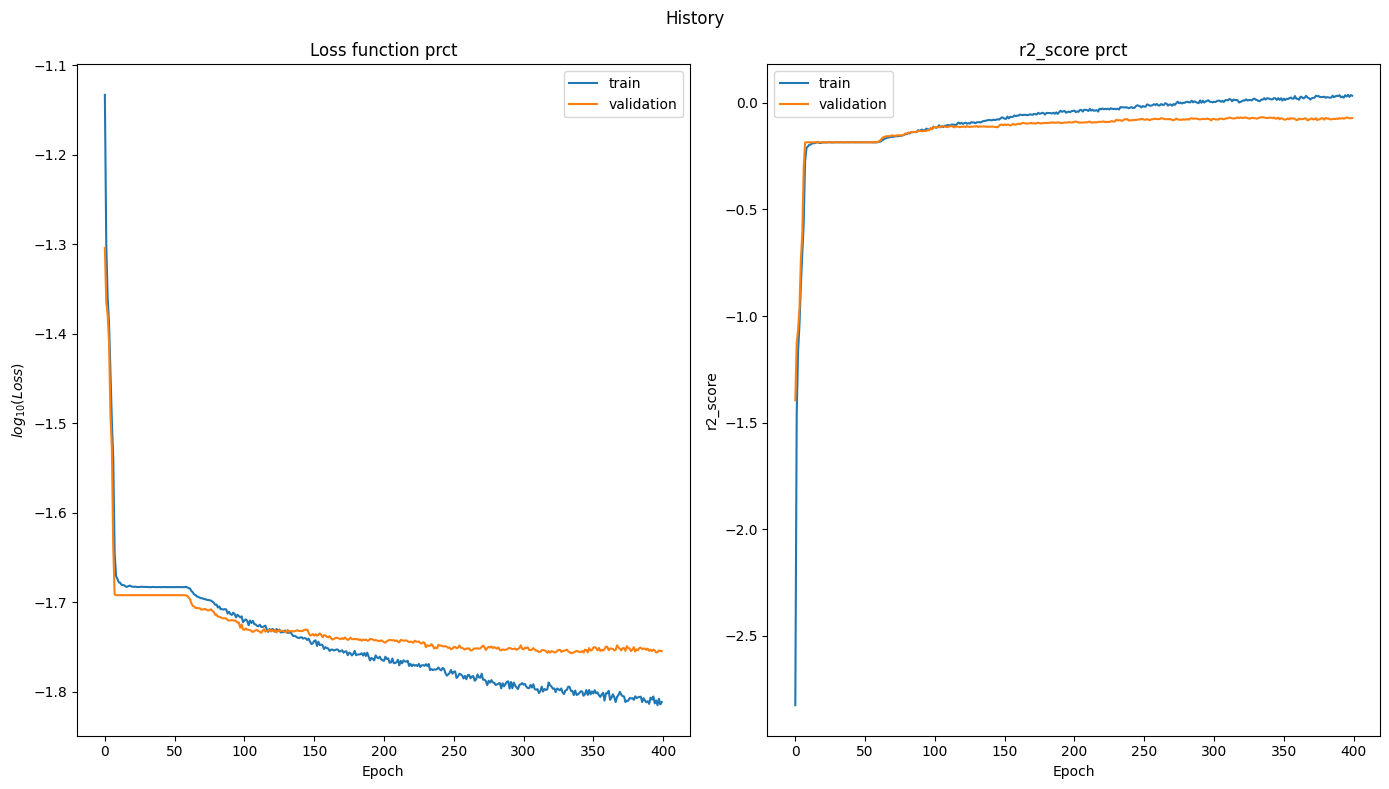

In [38]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 8))
fig.suptitle('History')
axs[0].plot(np.log10(testhistori_prct.history['loss']))
axs[0].plot(np.log10(testhistori_prct.history['val_loss']))
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('$log_{10}(Loss)$')
axs[0].legend(['train', 'validation'])
axs[0].set_title('Loss function prct')

axs[1].plot(testhistori_prct.history['r2_score'])
axs[1].plot(testhistori_prct.history['val_r2_score'])
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('r2_score')
axs[1].legend(['train', 'validation'])
axs[1].set_title('r2_score prct')

fig.tight_layout()
plt.show()

In [39]:
evaluation_loss = model.evaluate(Datas.get_val_dataloader())

23/23 [==============================] - 0s 2ms/step - loss: 0.0155 - r2_score: -0.2935 - root_mean_squared_error: 0.1245


In [40]:
loss_object = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.AdamW(learning_rate = 4e-4,weight_decay=1e-3)
r2_score = tf.keras.metrics.R2Score()
rmse = tf.keras.metrics.RootMeanSquaredError()

Datas.build_dataloader(model_type='both')
model = MyModel(model_selector='both')

model.compile(loss=loss_object,optimizer=optimizer,metrics=[r2_score,rmse])
testhistori_both = model.fit(Datas.get_train_dataloader(),epochs= 300 ,validation_data=Datas.get_test_dataloader(),batch_size=Batch_size)

Epoch 1/300
186/186 [==============================] - 2s 6ms/step - loss: 0.2332 - r2_score: -4.6380 - root_mean_squared_error: 0.4829 - val_loss: 0.1622 - val_r2_score: -1.0330 - val_root_mean_squared_error: 0.4027
Epoch 2/300
186/186 [==============================] - 1s 5ms/step - loss: 0.1543 - r2_score: -1.2550 - root_mean_squared_error: 0.3928 - val_loss: 0.1427 - val_r2_score: -0.7447 - val_root_mean_squared_error: 0.3777
Epoch 3/300
186/186 [==============================] - 1s 6ms/step - loss: 0.1371 - r2_score: -0.8519 - root_mean_squared_error: 0.3703 - val_loss: 0.1316 - val_r2_score: -0.5201 - val_root_mean_squared_error: 0.3628
Epoch 4/300
186/186 [==============================] - 1s 5ms/step - loss: 0.1265 - r2_score: -0.6481 - root_mean_squared_error: 0.3557 - val_loss: 0.1264 - val_r2_score: -0.4426 - val_root_mean_squared_error: 0.3555
Epoch 5/300
186/186 [==============================] - 1s 5ms/step - loss: 0.1200 - r2_score: -0.5286 - root_mean_squared_error: 0.3

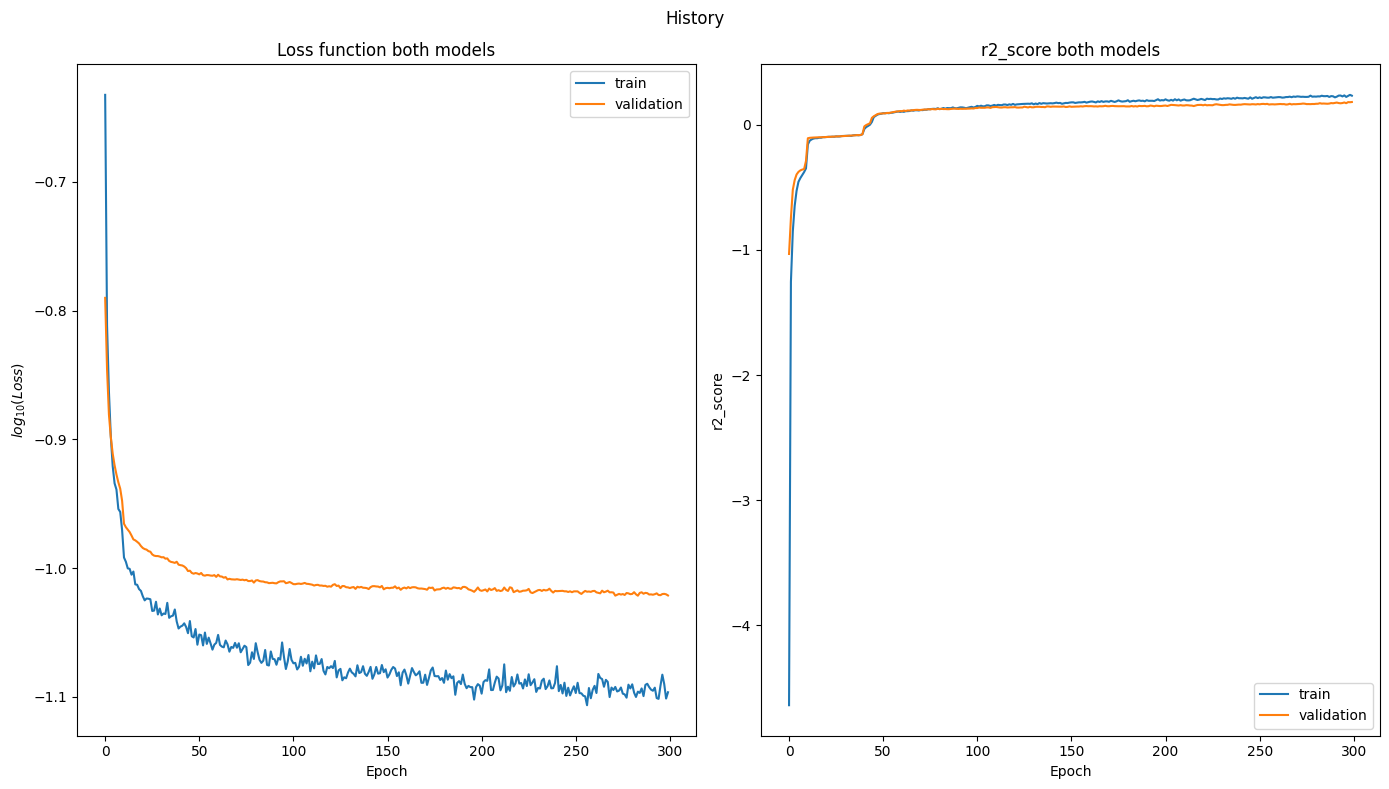

In [41]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 8))
fig.suptitle('History')
axs[0].plot(np.log10(testhistori_both.history['loss']))
axs[0].plot(np.log10(testhistori_both.history['val_loss']))
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('$log_{10}(Loss)$')
axs[0].legend(['train', 'validation'])
axs[0].set_title('Loss function both models')

axs[1].plot(testhistori_both.history['r2_score'])
axs[1].plot(testhistori_both.history['val_r2_score'])
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('r2_score')
axs[1].legend(['train', 'validation'])
axs[1].set_title('r2_score both models')

fig.tight_layout()
plt.show()

In [42]:
evaluation_loss = model.evaluate(Datas.get_val_dataloader())

23/23 [==============================] - 0s 1ms/step - loss: 0.0513 - r2_score: 0.2094 - root_mean_squared_error: 0.2265


### Training Tree Function


In [43]:
loss_object = tf.keras.losses.MeanSquaredError()
optimizer_prct = tf.keras.optimizers.AdamW(learning_rate = 6e-4,weight_decay=1e-3)
r2_score = tf.keras.metrics.R2Score()

model_Tree = tfdf.keras.GradientBoostedTreesModel(
    task = tfdf.keras.Task.REGRESSION,
    random_seed = SEED,
    output_dim = 7,
    num_trees=100
) 

Datas.build_dataloader(model_type='prct',batch_size = 1000)

model_Tree.compile(loss=loss_object,metrics=r2_score)
testhistori_prct = model_Tree.fit(Datas.get_train_dataloader(),validation_data=Datas.get_test_dataloader(),batch_size=Batch_size)



TypeError: GradientBoostedTreesModel.__init__() got an unexpected keyword argument 'output_dim'

In [ ]:
model_Tree.compile(metrics=r2_score)
evaluation = model_Tree.evaluate(Datas.get_val_dataloader())